## 결측값 처리

무작위로 발생한 결측값에 대해 세 가지 처리 결과를 비교합니다.
- 단순대체: 평균, 중위수
- 회귀추정
- 다중대체

### 실습 데이터셋 준비

In [1]:
# 관련 라이브러리를 호출합니다.
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
# iris 데이터셋을 호출하여 df에 할당합니다.
df = sns.load_dataset(name = 'iris')

In [3]:
# df의 정보를 확인합니다.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [4]:
# df의 처음 5행을 출력합니다.
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [5]:
# df에서 species가 'setosa'인 행을 선택하고 범주형 변수인 species를 삭제합니다.
df = df[df['species'].eq('setosa')].drop(columns = ['species'])

### 무작위로 결측값 생성

In [6]:
# df(원본)을 깊은 복사한 df1(복사본)을 생성합니다.
df1 = df.copy()

In [7]:
# 재현 가능한 결과를 얻기 위해 초기값을 설정합니다.
np.random.seed(seed = 1)

In [8]:
# df1의 열별로 행 길이의 20%를 무작위 결측값으로 대체합니다.
for i in range(df.shape[1]):
    n = int(df.shape[0] * 0.2)
    locs = np.random.choice(a = df.index, size = n, replace = False)
    df1.iloc[locs, i] = pd.NA

In [9]:
# 결측값을 강조하도록 설정합니다.
df1.style.highlight_null(color = 'red')

,sepal_length,sepal_width,petal_length,petal_width
0,5.100000,3.500000,1.400000,0.200000
1,4.900000,nan,1.400000,0.200000
2,nan,3.200000,1.300000,0.200000
3,nan,3.100000,1.500000,nan
4,5.000000,3.600000,1.400000,0.200000
5,5.400000,3.900000,nan,0.400000
6,4.600000,3.400000,1.400000,0.300000
7,5.000000,3.400000,1.500000,0.200000
8,4.400000,2.900000,1.400000,0.200000
9,4.900000,3.100000,1.500000,0.100000


### 결측값 패턴 확인

In [10]:
# 관련 라이브러리를 호출합니다.
import missingno as msno

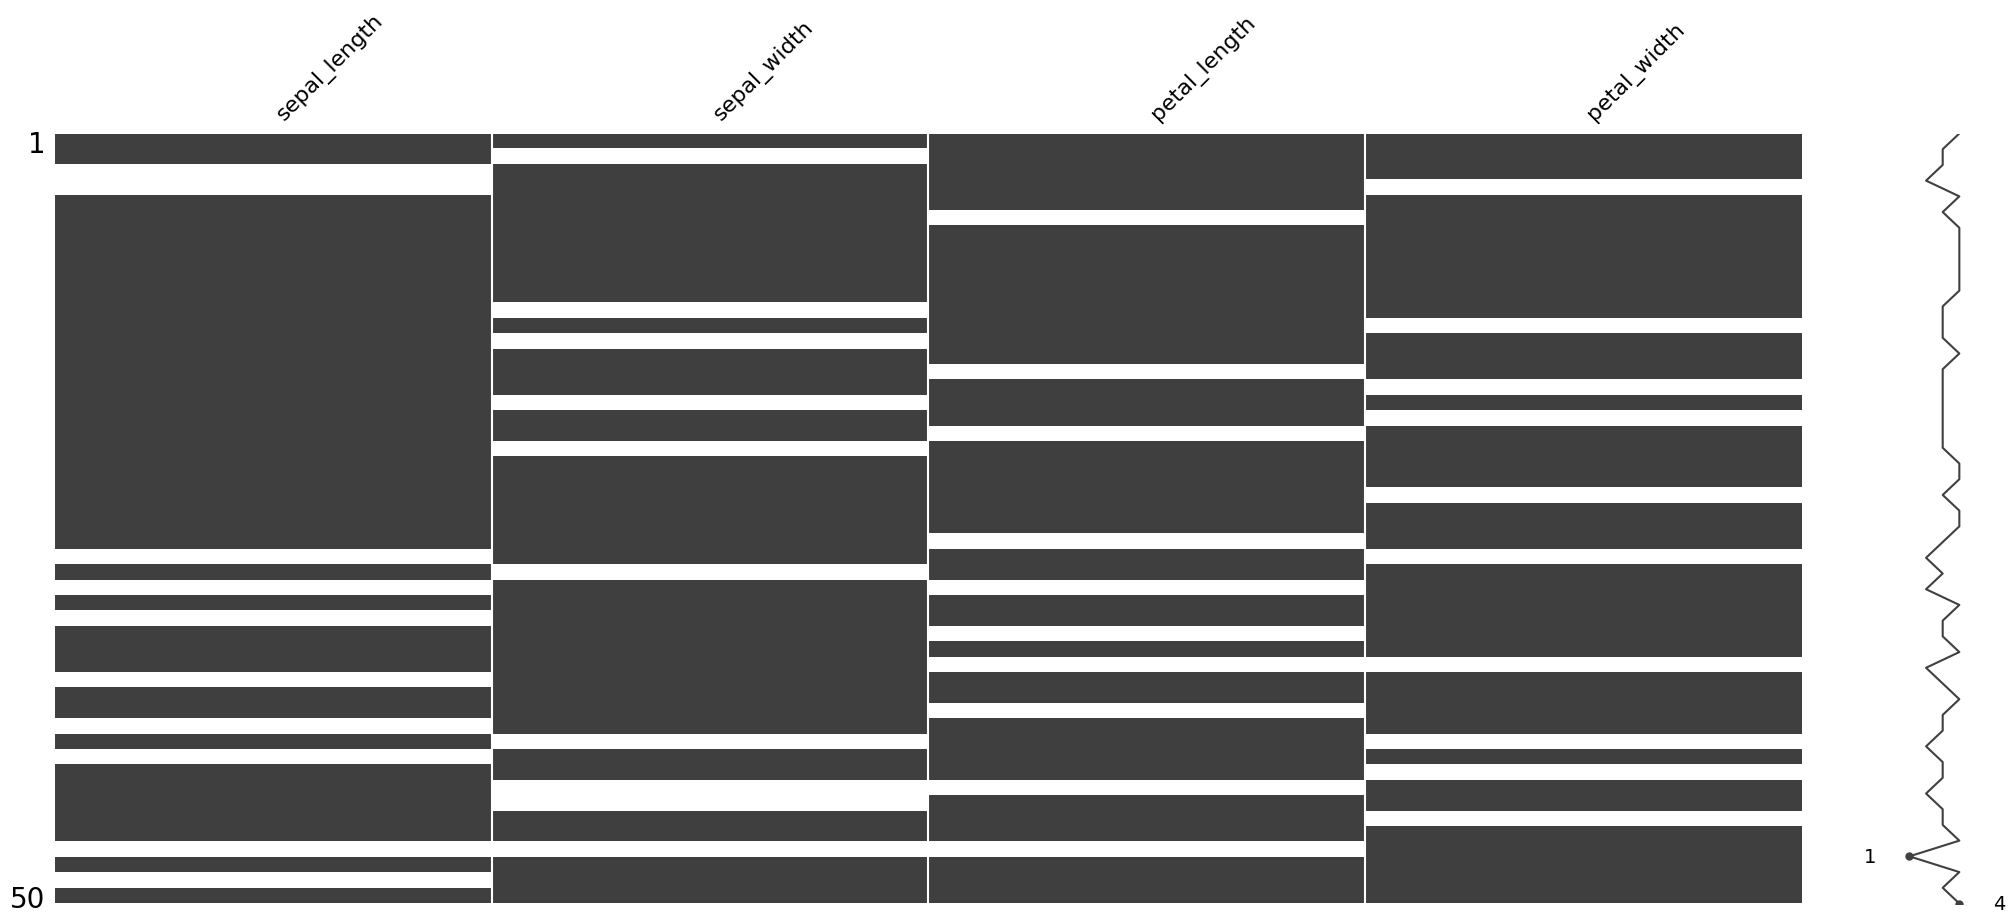

In [11]:
# 결측값(흰색) 패턴을 확인합니다.
# [참고] 여러 열에서 결측값이 있다면 열(변수)의 관계를 확인해야 합니다.
msno.matrix(df = df1);

### 단순대체

- mean: 평균
- median: 중위수
- most_frequent: 최빈값
- constant: 상수

In [12]:
# 관련 라이브러리를 호출합니다.
from sklearn.impute import SimpleImputer

In [13]:
# 결측값을 대체하는 함수를 생성합니다.
# [주의] X 매개변수에 수치형 변수만 데이터프레임 또는 2차원 배열로 지정해야 합니다.
def imputation(imputer, X):
    imputed = imputer.fit_transform(X)
    imputed = pd.DataFrame(data = imputed, columns = X.columns)
    return imputed

In [14]:
# 평균으로 단순대체한 결과를 si에 할당합니다.
si = imputation(
    imputer = SimpleImputer(strategy = 'mean'), 
    X = df1
)

In [15]:
# si의 처음 5행을 출력합니다.
si.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1000,3.500,1.4,0.2000
1,4.9000,3.445,1.4,0.2000
2,5.0225,3.200,1.3,0.2000
3,5.0225,3.100,1.5,0.2375
4,5.0000,3.600,1.4,0.2000


### 다중대체

더이상 mice 라이브러리를 지원하지 않는 것으로 보임

In [16]:
# 관련 라이브러리를 호출합니다.
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [17]:
# 회귀추정값으로 다중대체한 결과를 multi1에 할당합니다.
mi = imputation(
    imputer = IterativeImputer(max_iter = 100, random_state = 0),
    X = df1
)

In [18]:
# mi의 처음 5행을 출력합니다.
mi.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.100000,3.500000,1.4,0.200000
1,4.900000,3.323669,1.4,0.200000
2,4.829631,3.200000,1.3,0.200000
3,4.797149,3.100000,1.5,0.227422
4,5.000000,3.600000,1.4,0.200000


### 원본과 대체값 비교

In [19]:
# 원본과 대체값을 비교하는 함수를 생성합니다.
def comparison(varname, origin = df, missing = df1, single = si, multi = mi):
    
    # df1의 열이름에서 결측값인 인덱스를 생성합니다.
    locs = np.where(missing[varname].isna())
    
    # origin과 single, multi imputed의 지정된 열을 가로 방향으로 결합합니다.
    merged = pd.concat(
        objs = [origin[varname], single[varname], multi[varname]], 
        axis = 1
    )
    
    # merged의 열이름을 변경합니다.
    merged.columns = ['원본', '단순대체', '다중대체']
    
    # 결측값인 행만 반환합니다.
    return merged.loc[locs]

In [20]:
# sepal_length를 평균으로 단순대체한 결과를 원본과 비교합니다.
comparison(varname = 'sepal_length')

,원본,단순대체,다중대체
2,4.7,5.0225,4.829631
3,4.6,5.0225,4.797149
27,5.2,5.0225,5.060312
29,4.7,5.0225,4.851782
31,5.4,5.0225,5.002547
35,5.0,5.0225,4.813735
38,4.4,5.0225,4.698376
40,5.0,5.0225,5.031448
46,5.1,5.0225,4.987955
48,5.3,5.0225,5.189560


## End of Document